<a href="https://colab.research.google.com/github/s1m0nS/mapAI-UNet/blob/main/UNet_binary_segmentation_mapAI_small_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Binary semantic segmentation example using U-Net

https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial118_binary_semantic_segmentation_using_unet.ipynb

In [2]:
# Libraries

# Change runtime type in Colab

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # ignore tensorflow warnings
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' # allow GPU memory growth

import glob

import cv2
from PIL import Image

import numpy as np
from matplotlib import pyplot as pltd

from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

import tensorflow as tf
print(tf.test.gpu_device_name())
print('\n')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/device:GPU:0


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4961774449644966442
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14401011712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3854469889378741444
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Unzip dataset --> run only in Colab
import zipfile

mapai_zip = '/content/drive/MyDrive/datasets/mapai_small.zip'
zip_ref = zipfile.ZipFile(mapai_zip, 'r')
zip_ref.extractall("/tmp") # extracting dataset to tmp folder
zip_ref.close()

# Re-run from here after first run! 

In [5]:
# Configure paths

# training set
train_img_dir = '/tmp/mapai_small/train/images'
train_mask_dir = '/tmp/mapai_small/train/masks'

# validation set
val_img_dir = '/tmp/mapai_small/val/images'
val_mask_dir = '/tmp/mapai_small/val/masks'

# validation set
test_img_dir = '/tmp/mapai_small/test/images'
test_mask_dir = '/tmp/mapai_small/test/masks'

# parameters
SIZE = 500
train_num_images = 800
val_num_images = 200
test_num_images = 250

### Prepare data
https://github.com/HVL-ML/LAB-Net/blob/master/nbs/00a_mapai_prepare_data.ipynb

In [6]:
#!pip install datasets
#from datasets import load_dataset

from pathlib import Path
import shutil
import pandas as pd
import datetime

from PIL import Image
import numpy as np, matplotlib.pyplot as plt
import skimage

### Analyze buildings ###
def get_building_percentage(maskfn, plot=False):
    mask = Image.open(maskfn)
    if plot: 
        plt.imshow(mask)
        plt.axis('off')
        plt.show()
    total_area = np.prod(mask.size)
    mask_percentage = (np.sum(mask)/total_area)
    return mask_percentage

def count_buildings(maskfn, plot=False):
    mask = Image.open(maskfn)
    if plot: 
        plt.imshow(mask)
        plt.axis('off')
        plt.show()
    return len(np.unique(skimage.measure.label(np.array(mask))))-1

### TRAIN IMAGES

In [7]:
train_image_names = glob.glob('/tmp/mapai_small/train/images/*.png')
train_image_names.sort()
train_image_names_subset = train_image_names[0:train_num_images]
train_images = [cv2.imread(img, 0) for img in train_image_names_subset]
train_image_dataset = np.array(train_images)
train_image_dataset = np.expand_dims(train_image_dataset, axis = 3)

print(len(train_image_names))

800


### TRAIN MASKS

In [8]:
train_mask_names = glob.glob('/tmp/mapai_small/train/masks/*.png')
train_mask_names.sort()
train_mask_names_subset = train_mask_names[0:train_num_images]
train_masks = [cv2.imread(mask, 0) for mask in train_mask_names_subset]
train_mask_dataset = np.array(train_masks)
train_mask_dataset = np.expand_dims(train_mask_dataset, axis = 3)

print(len(train_mask_names))

800


#### Print properties of train images


In [9]:
print("Image data shape is: ", train_image_dataset.shape)
print("Mask data shape is: ", train_mask_dataset.shape)
print("Max pixel value in image is: ", train_image_dataset.max())
print("Labels in the mask are : ", np.unique(train_mask_dataset))

Image data shape is:  (800, 500, 500, 1)
Mask data shape is:  (800, 500, 500, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [10]:
# Store train images/masks in dictionary amd create dataframe

# mapAI
#train_data = {'image': train['image'], 'lidar': train['lidar'], 'mask': train['mask'], 'is_val':False}
train_data = {'image': train_image_names, 'mask': train_mask_names, 'is_val': False}

# Create dataframe from dictionary
train_df = pd.DataFrame.from_dict(train_data)
train_df.head()

,image,mask,is_val
0,/tmp/mapai_small/train/images/6051_689_0.png,/tmp/mapai_small/train/masks/6051_689_0.png,False
1,/tmp/mapai_small/train/images/6051_689_38.png,/tmp/mapai_small/train/masks/6051_689_38.png,False
2,/tmp/mapai_small/train/images/6051_689_4.png,/tmp/mapai_small/train/masks/6051_689_4.png,False
3,/tmp/mapai_small/train/images/6051_689_42.png,/tmp/mapai_small/train/masks/6051_689_42.png,False
4,/tmp/mapai_small/train/images/6051_689_44.png,/tmp/mapai_small/train/masks/6051_689_44.png,False


#### Calculate building mask percentage

In [11]:
train_df['mask_percentage'] = train_df['mask'].apply(get_building_percentage)
train_df.head()

,image,mask,is_val,mask_percentage
0,/tmp/mapai_small/train/images/6051_689_0.png,/tmp/mapai_small/train/masks/6051_689_0.png,False,20.70600
1,/tmp/mapai_small/train/images/6051_689_38.png,/tmp/mapai_small/train/masks/6051_689_38.png,False,6.37296
2,/tmp/mapai_small/train/images/6051_689_4.png,/tmp/mapai_small/train/masks/6051_689_4.png,False,44.64234
3,/tmp/mapai_small/train/images/6051_689_42.png,/tmp/mapai_small/train/masks/6051_689_42.png,False,4.77564
4,/tmp/mapai_small/train/images/6051_689_44.png,/tmp/mapai_small/train/masks/6051_689_44.png,False,47.96142


### Read validation dataset and perform the same steps

### VALIDATION IMAGES

In [12]:
val_image_names = glob.glob('/tmp/mapai_small/val/images/*.png')
val_image_names.sort()
val_image_names_subset = val_image_names[0:val_num_images]
val_images = [cv2.imread(img, 0) for img in val_image_names_subset]
val_image_dataset = np.array(val_images)
val_image_dataset = np.expand_dims(val_image_dataset, axis = 3)

print(len(val_image_names))

200


### VALIDATION MASKS


In [13]:
val_mask_names = glob.glob('/tmp/mapai_small/val/masks/*.png')
val_mask_names.sort()
val_mask_names_subset = val_mask_names[0:val_num_images]
val_masks = [cv2.imread(mask, 0) for mask in val_mask_names_subset]
val_mask_dataset = np.array(val_masks)
val_mask_dataset = np.expand_dims(val_mask_dataset, axis = 3)

print(len(val_mask_names))

200


#### Print properties of validation images

In [14]:
print("Image data shape is: ", val_image_dataset.shape)
print("Mask data shape is: ", val_mask_dataset.shape)
print("Max pixel value in image is: ", val_image_dataset.max())
print("Labels in the mask are : ", np.unique(val_mask_dataset))

Image data shape is:  (200, 500, 500, 1)
Mask data shape is:  (200, 500, 500, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


### Store validation images/masks in dictionary amd create dataframe

In [15]:
val_data = {'image': val_image_names, 'mask': val_mask_names, 'is_val': True}

# Create dataframe from dictionary
val_df = pd.DataFrame.from_dict(val_data)
val_df.head()

# Calculate building percentage on validation
val_df['mask_percentage'] = val_df['mask'].apply(get_building_percentage)
val_df.head()

,image,mask,is_val,mask_percentage
0,/tmp/mapai_small/val/images/6259_564_19.png,/tmp/mapai_small/val/masks/6259_564_19.png,True,0.00000
1,/tmp/mapai_small/val/images/6259_564_2.png,/tmp/mapai_small/val/masks/6259_564_2.png,True,56.09592
2,/tmp/mapai_small/val/images/6259_564_24.png,/tmp/mapai_small/val/masks/6259_564_24.png,True,51.30906
3,/tmp/mapai_small/val/images/6259_564_31.png,/tmp/mapai_small/val/masks/6259_564_31.png,True,44.22822
4,/tmp/mapai_small/val/images/6259_564_34.png,/tmp/mapai_small/val/masks/6259_564_34.png,True,47.46468


### TEST IMAGES

In [16]:
test_image_names = glob.glob('/tmp/mapai_small/test/images/*.png')
test_image_names.sort()
test_image_names_subset = test_image_names[0:test_num_images]
test_images = [cv2.imread(img, 0) for img in test_image_names_subset]
test_image_dataset = np.array(test_images)
test_image_dataset = np.expand_dims(test_image_dataset, axis = 3)

print(len(test_image_names))

250


### TEST MASKS

In [17]:
test_mask_names = glob.glob('/tmp/mapai_small/test/masks/*.png')
test_mask_names.sort()
test_mask_names_subset = test_mask_names[0:test_num_images]
test_masks = [cv2.imread(mask, 0) for mask in test_mask_names_subset]
test_mask_dataset = np.array(test_masks)
test_mask_dataset = np.expand_dims(test_mask_dataset, axis = 3)

print(len(test_mask_names))

250


#### Print properties of test images

In [18]:
print("Image data shape is: ", test_image_dataset.shape)
print("Mask data shape is: ", test_mask_dataset.shape)
print("Max pixel value in image is: ", test_image_dataset.max())
print("Labels in the mask are : ", np.unique(test_mask_dataset))

Image data shape is:  (250, 500, 500, 1)
Mask data shape is:  (250, 500, 500, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


#### Store test images/masks in dictionary and create dataframe

In [19]:
# mapAI
#train_data = {'image': train['image'], 'lidar': train['lidar'], 'mask': train['mask'], 'is_val':False}

test_data = {'image': test_image_names, 'mask': test_mask_names, 'is_val': False}

# Create dataframe from dictionary
test_df = pd.DataFrame.from_dict(test_data)
test_df.head()

,image,mask,is_val
0,/tmp/mapai_small/test/images/6051_690_13.png,/tmp/mapai_small/test/masks/6051_690_13.png,False
1,/tmp/mapai_small/test/images/6078_637_91.png,/tmp/mapai_small/test/masks/6078_637_91.png,False
2,/tmp/mapai_small/test/images/6078_638_24.png,/tmp/mapai_small/test/masks/6078_638_24.png,False
3,/tmp/mapai_small/test/images/6078_638_99.png,/tmp/mapai_small/test/masks/6078_638_99.png,False
4,/tmp/mapai_small/test/images/6084_553_93.png,/tmp/mapai_small/test/masks/6084_553_93.png,False


#### Concatenate train and validation dataframes into one

In [20]:
df = pd.concat([train_df, val_df]).reset_index(drop=True)

In [21]:
# add a new column make it False
df['is_building'] = False

# if mask_percentage > 0 then building = True
df.loc[df['mask_percentage'] > 0, 'is_building'] = True

print(len(df))

df.head()

1000


,image,mask,is_val,mask_percentage,is_building
0,/tmp/mapai_small/train/images/6051_689_0.png,/tmp/mapai_small/train/masks/6051_689_0.png,False,20.70600,True
1,/tmp/mapai_small/train/images/6051_689_38.png,/tmp/mapai_small/train/masks/6051_689_38.png,False,6.37296,True
2,/tmp/mapai_small/train/images/6051_689_4.png,/tmp/mapai_small/train/masks/6051_689_4.png,False,44.64234,True
3,/tmp/mapai_small/train/images/6051_689_42.png,/tmp/mapai_small/train/masks/6051_689_42.png,False,4.77564,True
4,/tmp/mapai_small/train/images/6051_689_44.png,/tmp/mapai_small/train/masks/6051_689_44.png,False,47.96142,True


#### How many buildings do we have all together?

In [22]:
# How many buildings do we all together?
print("Training set size: ", train_df.shape[0])
print("Validation set size: ", val_df.shape[0])
print()

# Calculate percentage of buildings
total = train_df.shape[0] + val_df.shape[0]
perc_buildings = round((df.is_building.value_counts()[0]/total) * 100, 2)
perc_other = round((df.is_building.value_counts()[1]/total) * 100, 2)

print("Buildings: ", perc_buildings, "%")
print("Other: ", perc_other, "%")

# from df
df.is_building.value_counts()

Training set size:  800
Validation set size:  200

Buildings:  22.8 %
Other:  77.2 %


True     772
False    228
Name: is_building, dtype: int64

#### Save to CSV

In [23]:
# Save to MyDrive/MapAI
df.to_csv(f"/content/drive/MyDrive/MapAI/train_val_original-{datetime.date.today()}.csv", index=False)

## Inspect data


In [24]:
# Read back saved csv

csv_path = "/content/drive/MyDrive/MapAI/train_val_original-2023-02-10.csv"

df = pd.read_csv(csv_path)

In [25]:
from pathlib import Path
from PIL import Image
import numpy as np, pandas as  pd, matplotlib.pyplot as plt


#### Plots ####

def plot_image_and_masks_from_df(imgidx, df, figsize=6, with_segm=True):
    imgfn = str(df.iloc[imgidx]['image'])
    print(imgfn)
    if with_segm:
        maskfn = df.iloc[imgidx]['mask']
        print(maskfn)
    f, ax = plt.subplots(figsize=(figsize,figsize))
    img = Image.open(imgfn)
    ax.imshow(img)
    if with_segm:
        mask = Image.open(maskfn)
        ax.imshow(mask, alpha=0.3)
    imgid = imgfn.split("/")[-1].split(".")[0]
    imgsz = img.size
    ax.set_title(f'{imgid}, {str(imgsz)}')
    ax.set_axis_off()
    return ax

def plot_image_lidar_and_masks_from_df(imgidx, df, figsize=6, with_segm=True):
    imgfn = str(df.iloc[imgidx]['image'])
    lidarfn = str(df.iloc[imgidx]['lidar'])
    if with_segm:
        maskfn = df.iloc[imgidx]['mask']
    f, ax = plt.subplots(1,2, figsize=(figsize,figsize))
    img = Image.open(imgfn)
    lidar = np.array(Image.open(lidarfn))
    ax[0].imshow(img)
    ax[1].imshow(img)
    if with_segm:
        mask = Image.open(maskfn)
        ax[0].imshow(mask, alpha=0.3)
        ax[1].imshow(lidar, alpha=0.3)
    imgid = imgfn.split("/")[-1].split(".")[0]
    imgsz = img.size
    ax[0].set_title(f'{imgid}, {str(imgsz)}')
    ax[0].set_axis_off()
    return ax

from ipywidgets import interact, interactive, IntSlider, Select, RadioButtons, fixed, BoundedIntText


### Code for interactive plot
interactive_plot = interactive(plot_image_and_masks_from_df, df=fixed(df),
                               imgidx = BoundedIntText(min=0, max=len(df)-1, step=1, value=0),
                               figsize = BoundedIntText(min=4, max=12, step=1, value=6),
                               with_segm= RadioButtons(options=[True,False], value=True, 
                                                      description="With segmentation"))

output = interactive_plot.children[-1]

In [26]:
### START INTERACTIVE PLOTTING ###
interactive_plot

# image indexes are messed up --> SOLVED --> Forgot to add after glob.glob()
# IMAGES -> index 0 --> 6084_552_87.png --> incorrect middle picture in folder
# MASKS -> index 0 --> 6051_689_0.png --> correct first picture in folder

interactive(children=(BoundedIntText(value=0, description='imgidx', max=999), BoundedIntText(value=6, descript…

#### Normalize images
Getting OOM errors, maybe need to find a better way to normalize images.

In [27]:
# IMAGES
# Solution: https://stackoverflow.com/questions/62977311/how-can-i-stop-my-colab-notebook-from-crashing-while-normalising-my-images
# float16 or float32? Find answer

# Can also normalize or scale using MinMax scaler

# IMAGES
train_image_dataset = (train_image_dataset / 255.0).astype(np.float16)
val_image_dataset = (val_image_dataset / 255.0).astype(np.float16)
test_image_dataset = (test_image_dataset / 255.0).astype(np.float16)

# MASKS
train_mask_dataset = (train_mask_dataset / 255.0).astype(np.float16)  
val_mask_dataset = (val_mask_dataset / 255.0).astype(np.float16)
test_mask_dataset = (test_mask_dataset / 255.0).astype(np.float16)

# Is this correct? Yes, should be. Pixel values will be 0 or 1

In [28]:
# Plot normalized images

# way to gey one pixel
train_image_dataset[0][0][0], train_mask_dataset[0][0][0]
val_image_dataset[0][0][0], val_mask_dataset[0][0][0]
test_image_dataset[0][0][0], test_mask_dataset[0][0][0]


(array([0.1059], dtype=float16), array([0.], dtype=float16))

In [29]:
print('# TRAINING: ', len(train_image_dataset), len(train_mask_dataset))
print('# VALIDATION: ', len(val_image_dataset), len(val_mask_dataset))
print('# TEST: ', len(test_image_dataset), len(test_mask_dataset))

# TRAINING:  800 800
# VALIDATION:  200 200
# TEST:  250 250


### Initialize train / val/ test

In [30]:
X_train, y_train = (train_image_dataset, train_mask_dataset)
X_val, y_val = (val_image_dataset, val_mask_dataset)
X_test, y_test = (test_image_dataset, test_mask_dataset)

### Resize images to approptiate shape for UNet

In [31]:
def resize(image, mask):
    input_image = tf.image.resize(image, (480, 480), method='bicubic')
    input_mask = tf.image.resize(mask, (480, 480), method='bicubic')
    return input_image, input_mask

# Apply
X_train, y_train = resize(X_train, y_train)
X_val, y_val = resize(X_val, y_val)
X_test, y_test = resize(X_test, y_test)

# What happens if you resize to 512? Need to test it

### Convert EagerTensor to numpy array

In [ ]:
# Convert EagerTensor to ndarray to perform data augmentation
#X_train = X_train.numpy()
#y_train = y_train.numpy()

#### Apply Data Augmentation

https://www.youtube.com/watch?v=JI8saFjK84o

*   Geometric transformations – you can randomly flip, crop, rotate or translate images.
*  Color space transformations – change RGB color channels, intensify any color
*  Kernel filters – sharpen or blur an image 
*   Random Erasing – delete a part of the initial image
*   Mixing images – basically, mix images with one another.

Only on training. Data augmentation is used to increase the size of the training set and to get more different images.

CNNs out of the box are not scale and rotation invariant.

In [ ]:
'''
# FIRST TRY WITHOUT, THEN SEE DIFFERENCE

# Alex
# batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), Saturation(),
#            Zoom(), Normalize.from_stats(*imagenet_stats)] #RandomErasing()


def augmentations(image, mask):
  # https://www.tensorflow.org/api_docs/python/tf/image
  
  # Random cropping
  image = tf.image.random_crop(image)
  mask = tf.image.random_crop(mask)
  
  # Random brightness
  image = tf.image.random_brightness(image, max_delta=0.5)
  mask = tf.image.random_brightness(mask, max_delta=0.5)
  # Random flipping
  image = tf.image.random_flip_left_right(image, seed=42)
  mask = tf.image.random_flip_left_right(mask, seed=42)
  # Random flipping up and down
  image = tf.image.random_flip_up_down(image, seed=42)
  mask = tf.image.random_flip_up_down(mask, seed=42)
  # Rotate image 90 degrees
  image = tf.image.rot90(image, k=1) # k --> number of rotations
  mask = tf.image.rot90(mask, k=1) # k --> number of rotations
  
  return image, mask


# Apply augmentations on the training set
X_train, y_train = augmentations(X_train, y_train)

'''

'\n# FIRST TRY WITHOUT, THEN SEE DIFFERENCE\n\n# Alex\n# batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), Saturation(),\n#            Zoom(), Normalize.from_stats(*imagenet_stats)] #RandomErasing()\n\n\ndef augmentations(image, mask):\n  # https://www.tensorflow.org/api_docs/python/tf/image\n  \n  # Random cropping\n  image = tf.image.random_crop(image)\n  mask = tf.image.random_crop(mask)\n  \n  # Random brightness\n  image = tf.image.random_brightness(image, max_delta=0.5)\n  mask = tf.image.random_brightness(mask, max_delta=0.5)\n  # Random flipping\n  image = tf.image.random_flip_left_right(image, seed=42)\n  mask = tf.image.random_flip_left_right(mask, seed=42)\n  # Random flipping up and down\n  image = tf.image.random_flip_up_down(image, seed=42)\n  mask = tf.image.random_flip_up_down(mask, seed=42)\n  # Rotate image 90 degrees\n  image = tf.image.rot90(image, k=1) # k --> number of rotations\n  mask = tf.image.rot90(mask, k=1) # k --> number of rotations\n 

In [ ]:
#### DATA AUGMENTATION WORKING

print(type(X_train))
print(type(y_train))

print(len(X_train))
print(len(y_train))

# Flip --> Fucking works!
Vx = [tf.image.random_flip_left_right(image, seed=42) for image in X_train]
Vy = [tf.image.random_flip_left_right(mask, seed=42) for mask in y_train]

# Random flip up-down
#Ux = [tf.image.random_flip_up_down(image, seed=42) for image in X_train]
#Uy = [tf.image.random_flip_up_down(mask, seed=42) for mask in y_train]

# Append augmented images and masks to train dataset

X_train = np.append(X_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

#X_train = np.append(X_train, Ux, axis=0)
#y_train = np.append(y_train, Uy, axis=0)


#X_train = tf.experimental.numpy.append(X_train, Vx, axis=0)

print(len(X_train))
print(len(y_train))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
800
800
1600
1600


In [ ]:
# Save one augmented instance as image
# needs a solution


AttributeError: ignored

### U-Net


In [ ]:
# Building Unet by dividing encoder and decoder into blocks

# https://www.youtube.com/watch?v=GAYJ81M58y8&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=21

# Add weight regularizer 
# Having more layers does not help sometimes
# Try to decrease the complexity of the model and see the results
# You can start with a more complicated model and add some regularization

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x) #halfes the resoltuion
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    # Decrease the number of filters

    s1, p1 = encoder_block(inputs, 60)
    s2, p2 = encoder_block(p1, 120)
    s3, p3 = encoder_block(p2, 240)
    s4, p4 = encoder_block(p3, 480)

    b1 = conv_block(p4, 960) #Bridge

    d1 = decoder_block(b1, s4, 480)
    d2 = decoder_block(d1, s3, 240)
    d3 = decoder_block(d2, s2, 120)
    d4 = decoder_block(d3, s1, 60)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(480, 480, 1)


In [ ]:
# Build the model
# Check if you are using correct metrics?
# https://keras.io/api/metrics/segmentation_metrics/

model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

### Train model
https://www.youtube.com/watch?v=7j0yL8A-k4E

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs= 100, 
                    validation_data=(X_val, y_val), 
                    shuffle=False)

# Colab
# System RAM: 9.7/12.7
# GPU RAM: 14.3/15

# Training on CPU --> 1 epoch; 6:37 hours
# 

# Something is wrong with the training set, but what?rt a new axis that will appear at the axis position in the expanded array shape.

Parameters:


# TEST 1: 10 epochs without data augmentation
# 
# TEST 2: 10 epochs with data augmentation

# TEST 3: 100 epochs, learning rate = 1e-3

In [ ]:
# Copy/paste losses from previous training
# TEST 1: 10 epochs without data augmentation

'''
Epoch 1/10
200/200 [==============================] - 220s 985ms/step - loss: 0.3384 - accuracy: 0.8501 - val_loss: 9.9828 - val_accuracy: 0.0866
Epoch 2/10
200/200 [==============================] - 196s 979ms/step - loss: 0.2872 - accuracy: 0.8583 - val_loss: 1.4065 - val_accuracy: 0.7084
Epoch 3/10
200/200 [==============================] - 190s 949ms/step - loss: 0.2611 - accuracy: 0.8618 - val_loss: 1.1999 - val_accuracy: 0.8263
Epoch 4/10
200/200 [==============================] - 195s 977ms/step - loss: 0.2411 - accuracy: 0.8674 - val_loss: 0.4944 - val_accuracy: 0.8367
Epoch 5/10
200/200 [==============================] - 196s 981ms/step - loss: 0.2295 - accuracy: 0.8709 - val_loss: 1.2304 - val_accuracy: 0.8424
Epoch 6/10
200/200 [==============================] - 196s 982ms/step - loss: 0.2199 - accuracy: 0.8734 - val_loss: 1.1057 - val_accuracy: 0.8417
Epoch 7/10
200/200 [==============================] - 190s 952ms/step - loss: 0.2114 - accuracy: 0.8758 - val_loss: 1.1969 - val_accuracy: 0.8409
Epoch 8/10
200/200 [==============================] - 196s 980ms/step - loss: 0.2045 - accuracy: 0.8775 - val_loss: 1.3014 - val_accuracy: 0.8399
Epoch 9/10
200/200 [==============================] - 191s 953ms/step - loss: 0.1952 - accuracy: 0.8800 - val_loss: 0.8283 - val_accuracy: 0.8419
Epoch 10/10
200/200 [==============================] - 190s 952ms/step - loss: 0.1897 - accuracy: 0.8816 - val_loss: 0.6361 - val_accuracy: 0.8448

'''

In [ ]:
# 50 epochs

'''
Epoch 1/100
200/200 [==============================] - 222s 985ms/step - loss: 0.3954 - accuracy: 0.8496 - val_loss: 2.5133 - val_accuracy: 0.6093
Epoch 2/100
200/200 [==============================] - 190s 950ms/step - loss: 0.3737 - accuracy: 0.8546 - val_loss: 0.5483 - val_accuracy: 0.8396
Epoch 3/100
200/200 [==============================] - 190s 952ms/step - loss: 0.3450 - accuracy: 0.8533 - val_loss: 1.2551 - val_accuracy: 0.3587
Epoch 4/100
200/200 [==============================] - 190s 951ms/step - loss: 0.3199 - accuracy: 0.8547 - val_loss: 0.4149 - val_accuracy: 0.8400
Epoch 5/100
200/200 [==============================] - 195s 977ms/step - loss: 0.3191 - accuracy: 0.8538 - val_loss: 0.3942 - val_accuracy: 0.8433
Epoch 6/100
200/200 [==============================] - 195s 977ms/step - loss: 0.2801 - accuracy: 0.8596 - val_loss: 0.6491 - val_accuracy: 0.8423
Epoch 7/100
200/200 [==============================] - 195s 976ms/step - loss: 0.2645 - accuracy: 0.8621 - val_loss: 0.5595 - val_accuracy: 0.8409
Epoch 8/100
200/200 [==============================] - 195s 976ms/step - loss: 0.2508 - accuracy: 0.8643 - val_loss: 0.2703 - val_accuracy: 0.8552
Epoch 9/100
200/200 [==============================] - 195s 975ms/step - loss: 0.2366 - accuracy: 0.8674 - val_loss: 0.4832 - val_accuracy: 0.8413
Epoch 10/100
200/200 [==============================] - 195s 975ms/step - loss: 0.2302 - accuracy: 0.8692 - val_loss: 0.3456 - val_accuracy: 0.8460
Epoch 11/100
200/200 [==============================] - 189s 946ms/step - loss: 0.2365 - accuracy: 0.8692 - val_loss: 0.3194 - val_accuracy: 0.8509
Epoch 12/100
200/200 [==============================] - 195s 975ms/step - loss: 0.2178 - accuracy: 0.8747 - val_loss: 0.3111 - val_accuracy: 0.8543
Epoch 13/100
200/200 [==============================] - 195s 975ms/step - loss: 0.2164 - accuracy: 0.8748 - val_loss: 0.3479 - val_accuracy: 0.8470
Epoch 14/100
200/200 [==============================] - 195s 974ms/step - loss: 0.2223 - accuracy: 0.8724 - val_loss: 0.2993 - val_accuracy: 0.8456
Epoch 15/100
200/200 [==============================] - 189s 945ms/step - loss: 0.2070 - accuracy: 0.8761 - val_loss: 0.3198 - val_accuracy: 0.8530
Epoch 16/100
200/200 [==============================] - 194s 972ms/step - loss: 0.1990 - accuracy: 0.8789 - val_loss: 0.4148 - val_accuracy: 0.8487
Epoch 17/100
200/200 [==============================] - 195s 974ms/step - loss: 0.1933 - accuracy: 0.8799 - val_loss: 0.4316 - val_accuracy: 0.8494
Epoch 18/100
200/200 [==============================] - 189s 944ms/step - loss: 0.1851 - accuracy: 0.8827 - val_loss: 0.4638 - val_accuracy: 0.8515
Epoch 19/100
200/200 [==============================] - 194s 971ms/step - loss: 0.1761 - accuracy: 0.8851 - val_loss: 0.4525 - val_accuracy: 0.8496
Epoch 20/100
200/200 [==============================] - 189s 943ms/step - loss: 0.1691 - accuracy: 0.8868 - val_loss: 0.3884 - val_accuracy: 0.8563
Epoch 21/100
200/200 [==============================] - 194s 970ms/step - loss: 0.1572 - accuracy: 0.8903 - val_loss: 0.3282 - val_accuracy: 0.8597
Epoch 22/100
200/200 [==============================] - 194s 972ms/step - loss: 0.1711 - accuracy: 0.8860 - val_loss: 0.4444 - val_accuracy: 0.7428
Epoch 23/100
200/200 [==============================] - 194s 971ms/step - loss: 0.1584 - accuracy: 0.8891 - val_loss: 0.2712 - val_accuracy: 0.8564
Epoch 24/100
200/200 [==============================] - 189s 943ms/step - loss: 0.1410 - accuracy: 0.8943 - val_loss: 0.2806 - val_accuracy: 0.8559
Epoch 25/100
200/200 [==============================] - 194s 971ms/step - loss: 0.1345 - accuracy: 0.8962 - val_loss: 0.2933 - val_accuracy: 0.8074
Epoch 26/100
200/200 [==============================] - 189s 943ms/step - loss: 0.1293 - accuracy: 0.8978 - val_loss: 0.2247 - val_accuracy: 0.8699
Epoch 27/100
200/200 [==============================] - 194s 970ms/step - loss: 0.1235 - accuracy: 0.8994 - val_loss: 0.2255 - val_accuracy: 0.8553
Epoch 28/100
200/200 [==============================] - 194s 972ms/step - loss: 0.1182 - accuracy: 0.9010 - val_loss: 0.2480 - val_accuracy: 0.8609
Epoch 29/100
200/200 [==============================] - 194s 971ms/step - loss: 0.1163 - accuracy: 0.9014 - val_loss: 0.2387 - val_accuracy: 0.8708
Epoch 30/100
200/200 [==============================] - 188s 942ms/step - loss: 0.1071 - accuracy: 0.9041 - val_loss: 0.3721 - val_accuracy: 0.8611
Epoch 31/100
200/200 [==============================] - 194s 969ms/step - loss: 0.1290 - accuracy: 0.8977 - val_loss: 0.2412 - val_accuracy: 0.8399
Epoch 32/100
200/200 [==============================] - 188s 941ms/step - loss: 0.1523 - accuracy: 0.8915 - val_loss: 0.2038 - val_accuracy: 0.8708
Epoch 33/100
200/200 [==============================] - 193s 968ms/step - loss: 0.1159 - accuracy: 0.9019 - val_loss: 0.1795 - val_accuracy: 0.8732
Epoch 34/100
200/200 [==============================] - 194s 970ms/step - loss: 0.1015 - accuracy: 0.9058 - val_loss: 0.1778 - val_accuracy: 0.8712
Epoch 35/100
200/200 [==============================] - 194s 970ms/step - loss: 0.0971 - accuracy: 0.9072 - val_loss: 0.1695 - val_accuracy: 0.8824
Epoch 36/100
200/200 [==============================] - 194s 970ms/step - loss: 0.0848 - accuracy: 0.9107 - val_loss: 0.1674 - val_accuracy: 0.8780
Epoch 37/100
200/200 [==============================] - 194s 971ms/step - loss: 0.0787 - accuracy: 0.9124 - val_loss: 0.1782 - val_accuracy: 0.8786
Epoch 38/100
200/200 [==============================] - 194s 969ms/step - loss: 0.0730 - accuracy: 0.9140 - val_loss: 0.1809 - val_accuracy: 0.8716
Epoch 39/100
200/200 [==============================] - 194s 970ms/step - loss: 0.0723 - accuracy: 0.9140 - val_loss: 0.1887 - val_accuracy: 0.8741
Epoch 40/100
200/200 [==============================] - 194s 970ms/step - loss: 0.0714 - accuracy: 0.9142 - val_loss: 0.1824 - val_accuracy: 0.8768
Epoch 41/100
200/200 [==============================] - 194s 969ms/step - loss: 0.0763 - accuracy: 0.9130 - val_loss: 0.1650 - val_accuracy: 0.8802
Epoch 42/100
200/200 [==============================] - 194s 968ms/step - loss: 0.0669 - accuracy: 0.9154 - val_loss: 0.1707 - val_accuracy: 0.8846
Epoch 43/100
200/200 [==============================] - 194s 969ms/step - loss: 0.0614 - accuracy: 0.9171 - val_loss: 0.2252 - val_accuracy: 0.8628
Epoch 44/100
200/200 [==============================] - 194s 968ms/step - loss: 0.0682 - accuracy: 0.9150 - val_loss: 0.1928 - val_accuracy: 0.8729
Epoch 45/100
200/200 [==============================] - 193s 965ms/step - loss: 0.1234 - accuracy: 0.8997 - val_loss: 0.2352 - val_accuracy: 0.8536
Epoch 46/100
200/200 [==============================] - 193s 964ms/step - loss: 0.0699 - accuracy: 0.9147 - val_loss: 0.2052 - val_accuracy: 0.8766
Epoch 47/100
200/200 [==============================] - 193s 964ms/step - loss: 0.0644 - accuracy: 0.9162 - val_loss: 0.2042 - val_accuracy: 0.8846
Epoch 48/100
200/200 [==============================] - 193s 964ms/step - loss: 0.0534 - accuracy: 0.9192 - val_loss: 0.2052 - val_accuracy: 0.8872
Epoch 49/100
200/200 [==============================] - 193s 964ms/step - loss: 0.0476 - accuracy: 0.9208 - val_loss: 0.2303 - val_accuracy: 0.8861
Epoch 50/100
200/200 [==============================] - 193s 964ms/step - loss: 0.0440 - accuracy: 0.9217 - val_loss: 0.2440 - val_accuracy: 0.8875

'''

In [ ]:
# Save the model for future use
model.save('/content/drive/MyDrive/models/mapAI_100-epochs_train_val_test.hdf5')

NameError: ignored

In [ ]:
# Evaluate model on the test set
# model.evaluate(X_test, y_test) 

### Plot training and validation accuracy

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load previously saved model

In [32]:
#Load previously saved model
from keras.models import load_model

#model_path = '/content/drive/MyDrive/models/mapAI_100-epochs_train_val_test.hdf5'

# TEST
model_path = '/content/drive/MyDrive/models/mapAI_small_100-epochs.hdf5'

model = load_model(model_path, compile=False)

### Prediction

In [33]:
X_test.shape

TensorShape([250, 480, 480, 1])

In [34]:
# Works only with GPU

# IoU threshold
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

8/8 [==============================] - 97s 6s/step


In [35]:
from keras.metrics import MeanIoU

# binary classification --> 2 classes
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6907899


6051_690_13.png
1/1 [==============================] - 0s 22ms/step


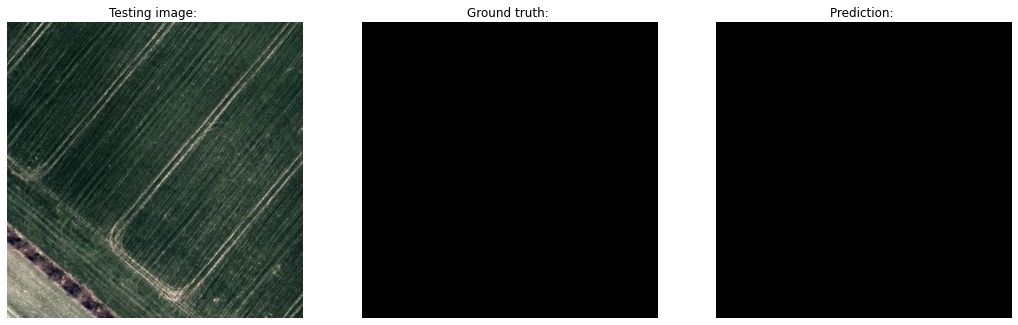

In [ ]:
import random
import gc

# PLOTTING RESULTS AS RGB

threshold = 0.5

# test_image_names
# test_image_names_subset --> ordered paths and names
#test_images --> arrays

# PLOT TEST IMAGES as RGB

# Test image number
n = 0
testImgName = str(Path(test_image_names_subset[n]).stem) + '.png'
print(testImgName)

# Make predicton on a test image specified with counter n
test_img = X_test[n]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(131)
ax1.set_title('Testing image: ')
image = cv2.imread(test_image_names_subset[n])[:,:,::-1]
ax1.imshow(image)
ax1.set_axis_off()

ax2 = fig.add_subplot(132)
ax2.set_title('Ground truth: ')
image = cv2.imread(test_mask_names_subset[n])[:,:,::-1]
ax2.imshow(image)
ax2.set_axis_off()

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction: ')
ax3.imshow(prediction, cmap='gray')
ax3.set_axis_off()

plt.savefig('/content/drive/MyDrive/predictions/' + testImgName, transparent=True) # better with transparent?

In [ ]:
# Do prediction on all of the 250 images

import random
import gc

# PLOTTING RESULTS AS RGB

threshold = 0.5

# test_image_names
# test_image_names_subset --> ordered paths and names
#test_images --> arrays

# PLOT TEST IMAGES as RGB

for n in range(len(test_image_names_subset)):
  gc.collect()
  # Test image number
  testImgName = str(Path(test_image_names_subset[n]).stem) + '.png'
  print(testImgName)

  # Make predicton on a test image specified with counter n
  test_img = X_test[n]
  test_img_input = np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

  fig = plt.figure(figsize=(18,12), dpi=200)
  ax1 = fig.add_subplot(131)
  ax1.set_title('Testing image: ')
  image = cv2.imread(test_image_names_subset[n])[:,:,::-1]
  ax1.imshow(image)
  ax1.set_axis_off()

  ax2 = fig.add_subplot(132)
  ax2.set_title('Ground truth: ')
  image = cv2.imread(test_mask_names_subset[n])[:,:,::-1]
  ax2.imshow(image)
  ax2.set_axis_off()

  ax3 = fig.add_subplot(133)
  ax3.set_title('Prediction: ')
  ax3.imshow(prediction, cmap='gray')
  ax3.set_axis_off()

  plt.savefig('/content/drive/MyDrive/predictions/' + testImgName)

6051_690_13.png
1/1 [==============================] - 4s 4s/step
6078_637_91.png
1/1 [==============================] - 0s 24ms/step
6078_638_24.png
1/1 [==============================] - 0s 23ms/step
6078_638_99.png
1/1 [==============================] - 0s 25ms/step
6084_553_93.png
1/1 [==============================] - 0s 24ms/step
6104_603_16.png
1/1 [==============================] - 0s 22ms/step
6112_694_95.png
1/1 [==============================] - 0s 38ms/step
6112_695_51.png
1/1 [==============================] - 0s 22ms/step
6121_864_12.png
1/1 [==============================] - 0s 22ms/step
6121_865_87.png
1/1 [==============================] - 0s 22ms/step
6122_519_17.png
1/1 [==============================] - 0s 21ms/step
6122_520_65.png
1/1 [==============================] - 0s 21ms/step
6123_531_70.png
1/1 [==============================] - 0s 30ms/step
6123_532_79.png
1/1 [==============================] - 0s 21ms/step
6124_676_45.png
1/1 [=============================

<ipython-input-36-929d0cde7837>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18,12), dpi=200)


6155_544_73.png
1/1 [==============================] - 0s 21ms/step
6165_679_45.png
1/1 [==============================] - 0s 21ms/step
6165_680_74.png
1/1 [==============================] - 0s 33ms/step
6170_651_64.png
1/1 [==============================] - 0s 22ms/step
6171_726_50.png
1/1 [==============================] - 0s 23ms/step
6171_726_83.png
1/1 [==============================] - 0s 21ms/step
6171_727_31.png
1/1 [==============================] - 0s 20ms/step
6171_727_69.png
1/1 [==============================] - 0s 21ms/step
6172_726_93.png
1/1 [==============================] - 0s 34ms/step
6173_631_91.png
1/1 [==============================] - 0s 21ms/step
6176_506_3.png
1/1 [==============================] - 0s 24ms/step
6188_600_1.png
1/1 [==============================] - 0s 22ms/step
6190_693_9.png
1/1 [==============================] - 0s 21ms/step
6190_693_97.png
1/1 [==============================] - 0s 21ms/step
6204_704_6.png
1/1 [==============================]

In [ ]:
threshold = 0.5

import random

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(20, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
#plt.savefig()

plt.show()

#### Problems




*   Test images and labels are different? Solved: Use sort()

## To solve:
*   Plot real color images not gray
*   other?



